## Setup

In [288]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats,signal
from scipy.optimize import curve_fit
from scipy.special import factorial

# Preparing Higgs Data
higg = open ("higgs_100000_pt_1000_1200.pkl",'rb')
higgD = pickle.load(higg)

# Preparing QCD Data
qcd = open ("qcd_100000_pt_1000_1200.pkl",'rb')
qcdD = pickle.load(qcd)

higgs_qcd_stuff = {
    "PT" : {
        "higgs_detail": {
            "legend_label":"Higgs Particle",
            "data": higgD['pt']       
        },
        "qcd_detail": {
            "legend_label":"QCD Background",
            "data": qcdD['pt']
        },
        "title":"Angular Momentum",
        "xlabel":"pt(GeV)",
    },
    "ETA": {
        "higgs_detail": {
            "legend_label":"Higgs Particle",
            "data": higgD['eta']       
        },
        "qcd_detail": {
            "legend_label":"QCD Background",
            "data": qcdD['eta']
        },
        "title":"Pseudorapidity",
        "xlabel":"n (-Pi to Pi)",
    },
    "PHI": {
        "higgs_detail": {
            "legend_label":"Higgs Particle",
            "data": higgD['phi']
            
        },
        "qcd_detail": {
            "legend_label":"QCD Background",
            "data": qcdD['phi']
        },
        "title":"Azimuthal Angle",
        "xlabel":"n (-Pi to Pi)",
    },
    "MASS": {
        "higgs_detail": {
            "legend_label":"Higgs Particle",
            "data": higgD['mass']
            
        },
        "qcd_detail": {
            "legend_label":"QCD Background",
            "data": qcdD['mass']
        },
        "title":"Mass",
        "xlabel":"Mass (GeV)",
    },
    "EE2": {
        "higgs_detail": {
            "legend_label":"Higgs Particle",
            "data": higgD['ee2']
            
        },
        "qcd_detail": {
            "legend_label":"QCD Background",
            "data": qcdD['ee2']
        },
        "title":"2-Point ECF Ratio"
    },
    "EE3": {
        "higgs_detail": {
            "legend_label":"Higgs Particle",
            "data": higgD['ee3']
            
        },
        "qcd_detail": {
            "legend_label":"QCD Background",
            "data": qcdD['ee3']
        },
        "title":"3-Point ECF Ratio"
    },
    "D2": {
        "higgs_detail": {
            "legend_label":"Higgs Particle",
            "data":higgD['d2']     
        },
        "qcd_detail": {
            "legend_label":"QCD Background",
            "data":qcdD['d2']
        },
        "title":"3-to-2 Point ECF Ratio"
    },
    "ANG": {
        "higgs_detail": {
            "legend_label":"Higgs Particle",
            "data":higgD['angularity']
            
        },
        "qcd_detail": {
            "legend_label":"QCD Background",
            "data":qcdD['angularity']
        },
        "title":"Angularity",
        "xlabel":"Angularity (tau_a)",
    },
    "T1": {
        "higgs_detail": {
            "legend_label":"Higgs Particle",
            "data":higgD['t1']   
        },
        "qcd_detail": {
            "legend_label":"QCD Background",
            "data":qcdD['t1']
        },
        "title":"Subjettiness - tau1"
    },
    "T2": {
        "higgs_detail": {
            "legend_label":"Higgs Particle",
            "data":higgD['t2']
        },
        "qcd_detail": {
            "legend_label":"QCD Background",
            "data":qcdD['t2']
        },
        "title":"Subjettiness - tau2"
    },
    "T3": {
        "higgs_detail": {
            "legend_label":"Higgs Particle",
            "data":higgD['t3']
        },
        "qcd_detail": {
            "legend_label":"QCD Background",
            "data":qcdD['t3']
        },
        "title":"Subjettiness - tau3"
    },
    "T21": {
        "higgs_detail": {
            "legend_label":"Higgs Particle",
            "data":higgD['t21']
        },
        "qcd_detail": {
            "legend_label":"QCD Background",
            "data":qcdD['t21']
        },
        "title":"Subjettiness - tau21"
    },
    "T32": {
        "higgs_detail": {
            "legend_label":"Higgs Particle",
            "data":higgD['t32']    
        },
        "qcd_detail": {
            "legend_label":"QCD Background",
            "data":qcdD['t32']
        },
        "title":"Subjettiness - tau32"
    },
    "KTDR": {
        "higgs_detail": {
            "legend_label":"Higgs Particle",
            "data":higgD['KtDeltaR']
        },
        "qcd_detail": {
            "legend_label":"QCD Background",
            "data":qcdD['KtDeltaR']
        },
        "title":"KtDeltaR"
    }
}

features_list = ['PT','ETA','PHI','MASS','EE2','EE3','D2','ANG','T1','T2','T3','T21','T32','KTDR']

In [289]:
"""This pair of methods will evaluate the significance of a given threshold for data selections"""

def eval_and_print(thresh_details):
    """Accepts dictionary of details related to the threshold
    Find the significance for Higgs Count and QCD Count (with normalizing factors 50 and 2000).
    Then prints significance based on the thresholds given"""
    
    numerator = 50*(thresh_details['hc']/100000)
    denominator = np.sqrt(2000*(thresh_details['qc']/100000))
    significance = numerator/denominator
         
    print(f"The significance if you use a threshold from {thresh_details['low_lim']}"
          f" to {thresh_details['high_lim']} on the {thresh_details['feature']} feature is: {significance}")
    
def count_in_threshold(low_lim, high_lim, feature, print_evaluation=True):
    """Must provide low limit, high limit, and the feature which you are evaluating
    Also accepts a boolean value to continue to print the significance. 
    Setting this to False will only provide a higgs and qcd background count
    
    Given the limits provided, counts how many background and 
    higgs particles remain after applying threshold limits.
    Passes counts to eval_and_print to be evaluated and printed"""

    # Start counts at 1 because indexing goes from 0-99999, 
    # which means if we start the count at 0 we will always be one short
    higgs_count=1
    qcd_count=1
    for hval,qval in zip(
        higgs_qcd_stuff[feature]['higgs_detail']['data'],
        higgs_qcd_stuff[feature]['qcd_detail']['data']):
        if low_lim <= hval <= high_lim:
            higgs_count+=1
        if low_lim <= qval <= high_lim:
            qcd_count+=1
    threshold_details = {
        "low_lim":low_lim,
        "high_lim":high_lim,
        "hc":higgs_count,
        "qc":qcd_count,
        "feature":higgs_qcd_stuff[feature]['title']
    }
    if print_evaluation:
        eval_and_print(threshold_details)    

In [307]:
def select_indexes(low_lim,high_lim,feature):
    """Must provide a low limit, high limit, and the feature which you are evaluating.
    Returns lists of indexes which are within the threshold"""
    
    indexes = []
    feature_list = list(feature)
    
    for qval in feature_list:
        if low_lim <= qval <= high_lim:
            indexes.append(feature_list.index(qval))
            
    return indexes

## Intro
In this part of the lab, I will use the selection of data with a pT range of 1000-1200

## Problem 1

Below is a stacked histogram of QCD background mass and optimized mass, both log-scale and non-log-scale. This visualization will be useful when we optimize our data.

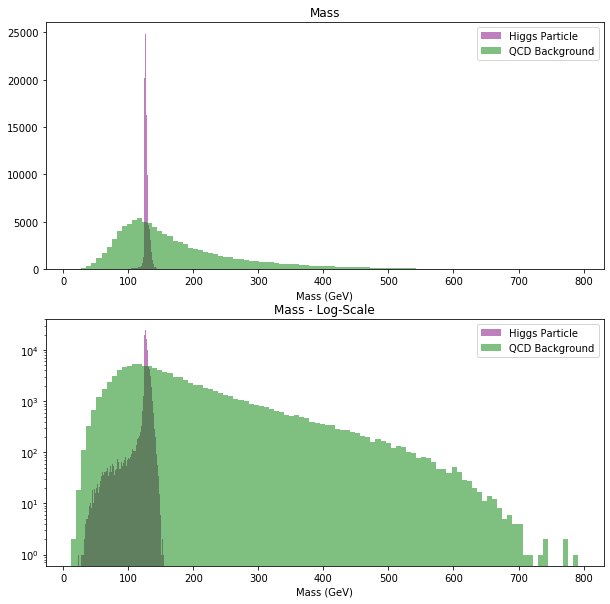

In [291]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))

for i in range(0,2):
    ax[i].hist(
        higgs_qcd_stuff['MASS']['higgs_detail']['data'],
        bins=100,
        color='purple',
        alpha=0.5,
        label='Higgs Particle')
    ax[i].hist(
        higgs_qcd_stuff['MASS']['qcd_detail']['data'],
        bins=100,
        color='green',
        alpha=0.5,
        label='QCD Background')
    ax[i].legend(loc='upper right')
    ax[i].set_xlabel("Mass (GeV)")

# Graph details that differ between log and non-log scale visualizations
ax[0].set_title(higgs_qcd_stuff['MASS']['title'])
ax[1].set_title(f"{higgs_qcd_stuff['MASS']['title']} - Log-Scale")
ax[1].set_yscale('log')

plt.show()

### We Ask the Question:
What would be our expected significance without first optimizing our data (or, assuming our background is already optimized), and how does it compare to the actual significance? 

Note that the true significance is equivalent to: $\frac{N_{higgs}}{\sqrt{N_{QCD}}}$

### Assumptions
We can first make a couple of assumptions based on the above. 
1. A Poisson fit will give us a high mean. This is because the majority of the background data lies far to the right of our true signal data, and so will increase the mean. 
2. A Poisson fit will not be a good fit. We know that a Poisson distribution is Gaussian-like when $\mu$ gets large. In the above visualizations see that this is not true, because the normal-scale visualization is not Gaussian, and the log-scale visualization is not a parabola. 
3. Because of the above, I expect our significance to be larger than it should be.

### Graphing The Best Fit Line
Below we graph the best-fit Poisson distribution whose mean is the same as that of our background data: 

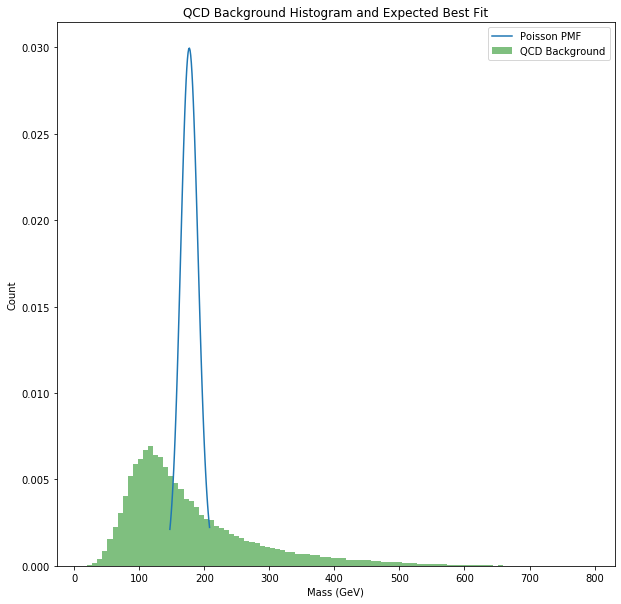

In [292]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

# Make Poisson representation with the mean of our background data
qcdMu = np.mean(higgs_qcd_stuff['MASS']['qcd_detail']['data'])
x = np.arange(stats.poisson.ppf(0.01, mu=qcdMu),stats.poisson.ppf(0.99, mu=qcdMu))

# Prepare the best-fit distribution
ax.plot(
    x, 
    stats.poisson.pmf(x, mu=qcdMu), 
    ms=4, 
    label='Poisson PMF')

# Prepare background data
ax.hist(higgs_qcd_stuff['MASS']['qcd_detail']['data'],
        bins=100,
        color='green',
        alpha=0.5, 
        label='QCD Background', 
        density=True)

# Set graph details
ax.legend(loc='upper right')
ax.set_title("QCD Background Histogram and Expected Best Fit")
ax.set_ylabel("Count")
ax.set_xlabel("Mass (GeV)")

plt.show()

With the above code, we know that the mean of our background, and what should be the mean of our Poisson best-fit distribution is 177.23 (the value of the variable qcdMu).

We will now find and compare our significance to  $\frac{N_{higgs}}{\sqrt{N_{QCD}}}$

In [293]:
cdf = stats.poisson.cdf(125,mu=177)
sig = stats.norm.ppf(cdf)
signif = 50/np.sqrt(2000)
print(f"'Best-Fit' Significance: {sig}")
print(f"Actual Significance: {signif}")

'Best-Fit' Significance: -4.072729796123784
Actual Significance: 1.118033988749895


### Moving Past Roadblocks
The above value for the best-fit significance in comparison to the actual significance shows that there is a lot of background noise that is throwing off our answer, and Poisson is not a good way to fit this data. If my assumptions as stated before were false, then this best-fit significance would have produced a number that was considerably closer than the value given. 

Because we do want to show that the value of $\frac{N_{higgs}}{\sqrt{N_{QCD}}}$ can be used as a reasonable method to find significance, we will instead use the mode. 
The mode of our data is the peak. If this were truly Poisson distributed, the mode and the mean would be the same, so we wouldn't need to bother with the difference between mode and mean. In this case, as stated, this is not Poisson distributed and so the mode and mean are not the same. However, we do care about the mode more than the mean in this case simply because this is where our 0$\sigma$ value lies. 
Below I use a value of 114, as this is the rounded mode of the background. 

In [294]:
cdfMode = stats.poisson.cdf(125,mu=114)
sigMode = stats.norm.ppf(cdfMode)
significance = 50/np.sqrt(2000)
print(f"'Best-Fit' Significance: {sigMode}")
print(f"Actual Significance: {significance}")

'Best-Fit' Significance: 1.0750588645079644
Actual Significance: 1.118033988749895


We can now conclude with certainty that the value of $\frac{N_{higgs}}{\sqrt{N_{QCD}}}$ can be used to find, or give a very good estimate of, significance. 

#### Problem 2

### We Ask the Question:
What threshold values would best optimize our background so that we can keep the maximum good data and also the minimum background data?

### Why We Ask this Question:
We have already established that there is an astounding amount of background noise that will always cause inacurate experiement outcomes (again, note the best-fit as calculated with the mean). So, we need to be able to cut the data at such a point that gives us the best possible significance (as compared to our known, actual significance). This means we have the find the perfect balance between throwing away good data, and keeping bad background data, such that it maximizes our chances of detecting the signal we're hunting for. 

### Method Moving Forward
We will use $\frac{N_{higgs}}{\sqrt{N_{QCD}}}$ to test our thresholds. 

First, we will identify a few thresholds which appear significant and should be part of our tests:
* Min/Max values
    * Chosen because these are the start and end of the entire array of data
* 100/150 
    * 100 appears to be where the data begins to be spiking upward
    * 140 appears to be where the data falls off sharply 
* 124/128
    * Arbitrary thresholds

Ideally, we want to keep any thresholds whose significance is close to that of our actual significance, 1.118

### Actually Moving Forward
We will find the values between these thresholds to count the values at and between the thresholds, and use $\frac{N_{higgs}}{\sqrt{N_{QCD}}}$ to find significance.

Once we have a chosen threshold, we will need to find the indexes of the values kept so that we can keep those in the other features. 

In [295]:
# Lists of high and low thresholds, respecitvely 
xlow = [min(round(higgs_qcd_stuff['MASS']['higgs_detail']['data'])),100,124]
xhigh = [max(round(higgs_qcd_stuff['MASS']['higgs_detail']['data'])),150,128]
    
for i in range(0,len(xlow)):
    count_in_threshold(xlow[i], xhigh[i],'MASS')

The significance if you use a threshold from 23.0 to 155.0 on the Mass feature is: 1.5300467864859666
The significance if you use a threshold from 100 to 150 on the Mass feature is: 1.95911751841519
The significance if you use a threshold from 124 to 128 on the Mass feature is: 4.164727780077581


### Conclusion
So, obviously we just want to use the threshold which includes all of our Higgs data (23-155). It is clear that losing even a few points can be severely detrimental to the significance.  

It is important to note, and is interesting to consider moving forward, that this is a perfect selection for our mass feature. That is, this is the best significance we can achieve with just mass (we can't include more good datapoints, and as soon as we omit, we get further from our actual significance).

## Problem 3
We want to have visualizations of all of our features.

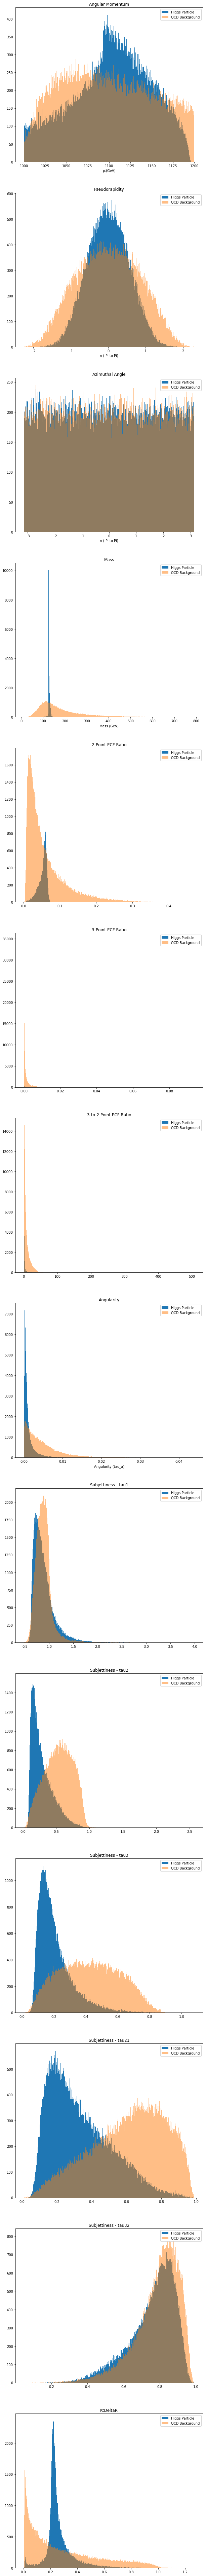

In [296]:
fig,ax=plt.subplots(14, 1, figsize=(10,140))

for i in range(len(features_list)):
    # Creating a histogram of Higgs data
    ax[i].hist(
        higgs_qcd_stuff.get(features_list[i]).get('higgs_detail').get('data',""),
        500,
        label=higgs_qcd_stuff.get(features_list[i]).get('higgs_detail').get('legend_label',""))
    # Creating a histogram of QCD data
    ax[i].hist(
        higgs_qcd_stuff.get(features_list[i]).get('qcd_detail').get('data',""),
        500,
        alpha=.5,
        label=higgs_qcd_stuff.get(features_list[i]).get('qcd_detail').get('legend_label',""))
    # Setting graph details that are not sensitive to data source
    ax[i].set_title(higgs_qcd_stuff.get(features_list[i]).get('title',""))
    ax[i].set_xlabel(higgs_qcd_stuff.get(features_list[i]).get('xlabel',""))
    ax[i].legend(loc='upper right')
    
plt.show() 
    
    

We should now decide if there are any other features that we could use in order to optimize our background data. 

As discussed in a previous lab, the following features are ones which we could utilize:

* **Invariant Mass**
    * Chosen due to the clear peak at 125 GeV, which is the known mass of the Higgs boson
* **Angularity** 
    * Chosen because of the clear peak the Higgs data has over the QCD background data. In addition, there are useful data in regards to decays given an upper and lower bound in the Higgs distribution.
* **$\tau$21** 
    * Is a suggested excellent jet discriminator between background and boosted object jets. This suggestion is validated based on the comparison between $\tau$21 and $\tau$32
    
### Optimizing with Mass
With the thresholds we ultimately found to be the best in Problem 2, we will now extract the data that we want from all features. First, we find the indexes of data kept. 

In [321]:
# Get the indexes of the values we want to retain using the method select_indexes
qcd_feature = higgs_qcd_stuff['MASS']['qcd_detail']['data']
qcd_mass_indexes = select_indexes(23,155,qcd_feature)

h_feature = higgs_qcd_stuff['MASS']['higgs_detail']['data']
h_mass_indexes = select_indexes(23,155,h_feature)

Now that we have the indexes, we will need to pull out the data we want to keep, and multiply each by the expected counts. 

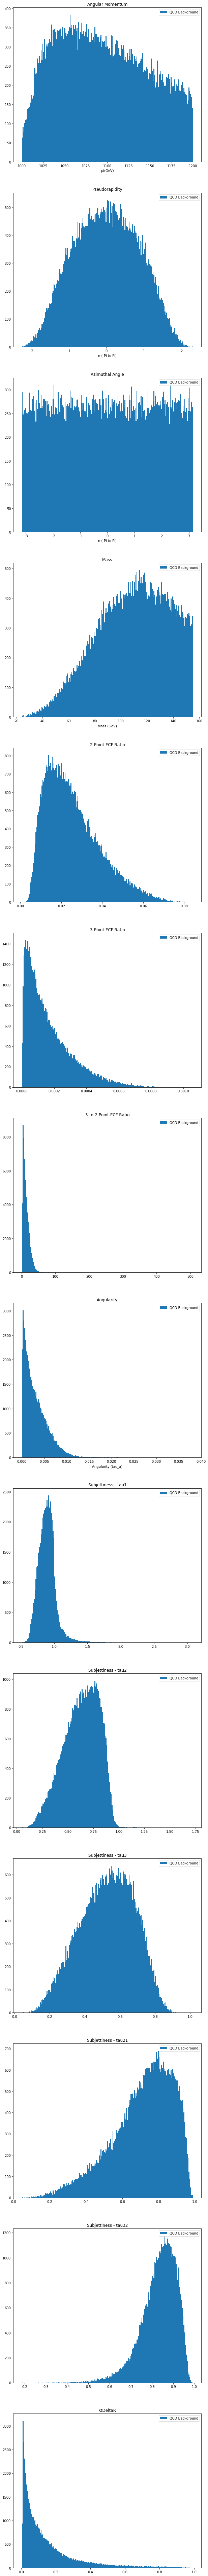

In [323]:
fig,ax=plt.subplots(14, 1, figsize=(10,140))

for i in range(len(features_list)):
    qcd_optimized_mass = []
    for ind in qcd_mass_indexes:
        qcd_optimized_mass.append((higgs_qcd_stuff.get(features_list[i]).get('qcd_detail').get('data',""))[ind])
        
    # Creating a histogram of QCD data
    ax[i].hist(
        qcd_optimized_mass,
        200,
        label=higgs_qcd_stuff.get(features_list[i]).get('qcd_detail').get('legend_label',''))  
    # Setting graph details that are not sensitive to data source
    ax[i].set_title(higgs_qcd_stuff.get(features_list[i]).get('title',''))  
    ax[i].set_xlabel(higgs_qcd_stuff.get(features_list[i]).get('xlabel',''))
    ax[i].legend(loc='upper right')
    
plt.show() 
    

### Moving Forward
The spike in mass at ~125 is not visible, which indicates the need for better optimization. In fact, it looks a bit like the spike is at ~115. 

I will now use the following optimizations (based on decisions made earlier, and in prior labs):  
* Angularity, with thresholds from 0-.01  
    * Chosen based on the above optimized background plots   
* Tau1, with thresholds from .6-1.25
    * Chosen based on the above optimized background plots

These estimates are based on the above preliminary optimizations.

In [299]:
count_in_threshold(0,.01,'ANG')
count_in_threshold(.6,1.25,'T1')

The significance if you use a threshold from 0 to 0.01 on the Angularity feature is: 1.1804553663255035
The significance if you use a threshold from 0.6 to 1.25 on the Subjettiness - tau1 feature is: 1.0628680146949008


## Problem 4   
### We Ask the Question:
Can we further optimize our data by including purposefully chosen thresholds on other features, and applying these constraints to the rest of the data?

### Why We Ask This:
We now want to see if the significance obtained by combining all thresholds together will be better than what we received simply from mass. The better we optimize the data (and the more noise we can remove), the more likely we are to detect a signal we're hunting for.    

### Method Forward
First, we will obtain a list of the features' indexes which fall within their respective thresholds.   
Then, we will create master lists of Higgs and QCD data separately.   
We will then uniquify those lists in order to have a list of indexes that are included in all thresholds together.  
That will get us counts for NHiggs and NQCD given our thresholds. From there we can use $\frac{N_{higgs}}{\sqrt{N_{QCD}}}$ to find significance again.

In [310]:
# Get the indexes of the values we want to retain
qcd_angularity_feature = higgs_qcd_stuff['ANG']['qcd_detail']['data']
qcd_t1_feature = higgs_qcd_stuff['T1']['qcd_detail']['data']

qcd_angularity_indexes = select_indexes(0,.01,qcd_angularity_feature)
qcd_tau_indexes = select_indexes(.6,1.25,qcd_t1_feature)

h_angularity_feature = higgs_qcd_stuff['ANG']['higgs_detail']['data']
h_t1_feature = higgs_qcd_stuff['T1']['higgs_detail']['data']

h_angularity_indexes = select_indexes(0,.01,h_angularity_feature)
h_tau_indexes = select_indexes(.6,1.25,h_t1_feature)

In [327]:
# Creating and uniquifying the master lists to use for significance, and graphing
qcd_master_list = []
higgs_master_list = []
qcd_master_list.extend(qcd_mass_indexes)
qcd_master_list.extend(qcd_angularity_indexes)
qcd_master_list.extend(qcd_tau_indexes)
higgs_master_list.extend(h_mass_indexes)
higgs_master_list.extend(h_angularity_indexes)
higgs_master_list.extend(h_tau_indexes)
qcd_unique_indexes = list(set(qcd_master_list))
higgs_unique_indexes = list(set(higgs_master_list))


# Find significance
numerator = 50*(len(higgs_unique_indexes)/100000)
denominator = np.sqrt(2000*(len(qcd_unique_indexes)/100000))
significance = numerator/denominator
         
print(f"The significance after applying ideal thresholds to Mass, Angularity, and Tau1"
        f" subjettiness features is: {significance}")


The significance after applying ideal thresholds to Mass, Angularity, and Tau1 subjettiness features is: 1.1202880352988582


### Quantitative Results
We got a significance of 1.12 when taking Angularity, $\tau$1 Subjettiness, and Mass all into consideration.   
Initially, with only mass, we got significance = 1.53.  

With the values giving with the data, the actual value of $\frac{N_{higgs}}{\sqrt{N_{QCD}}}$ is 1.118.  

So we can say with confidence that only optimizing our data based on what is actually the perfect subset for our mass is highly insufficient.   


### Qualitative Results  
Our math shows that our significance is much better with multiple features used as contraints than just one feature.   

Let us now explore the effect that has on our visualizations:

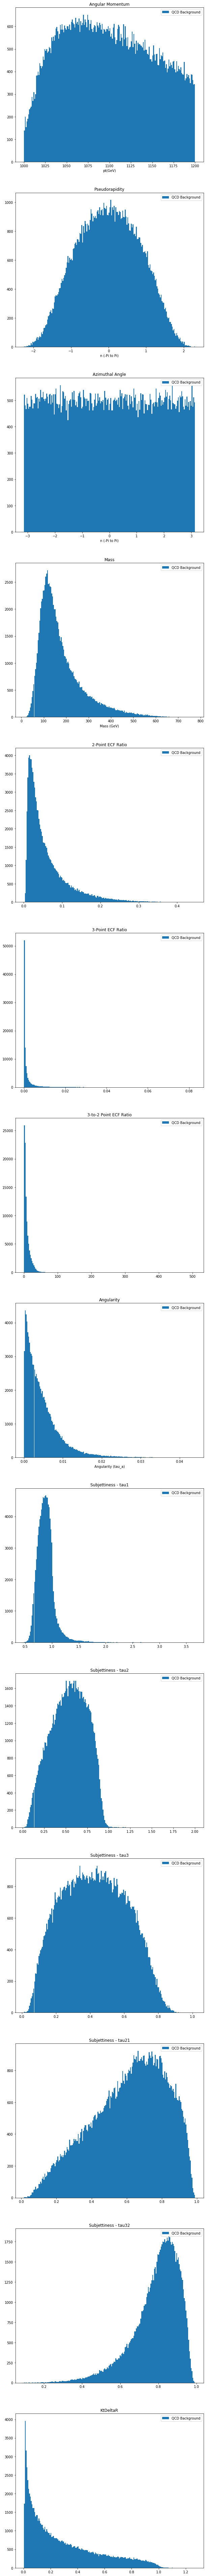

In [326]:
fig,ax=plt.subplots(14, 1, figsize=(10,140))

for i in range(len(features_list)):
    qcd_optimized_fin = []
    for j in qcd_unique_indexes:
        qcd_optimized_fin.append((higgs_qcd_stuff.get(features_list[i]).get('qcd_detail').get('data',""))[j])
        
    # Creating a histogram of QCD data
    ax[i].hist(
        qcd_optimized_fin,
        200,
        label=higgs_qcd_stuff.get(features_list[i]).get('qcd_detail').get('legend_label',''))  
    # Setting graph details that are not sensitive to data source
    ax[i].set_title(higgs_qcd_stuff.get(features_list[i]).get('title',''))  
    ax[i].set_xlabel(higgs_qcd_stuff.get(features_list[i]).get('xlabel',''))
    ax[i].legend(loc='upper right')
    
plt.show() 

### Conclusion 
We can see that the spike in the Mass graph lines up better with our expected value of ~125. However, it is not nearly as dramatic as it is in the optimized Higgs data. 

With that being said, given what we have just accomplished, if we took thresholds for all of our features and applied it to our background, we can expect our background to look more like our optimized data with ever added optimized feature.